## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [53]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [54]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

In [56]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [4]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [5]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

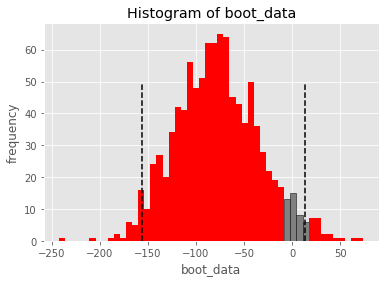

In [59]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [7]:
booted_data["p_value"] # альфа

0.07704553867678232

In [8]:
booted_data["quants"] # ДИ

0
0.025 -161.943418
0.975    5.328283

In [38]:
data_ab = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [39]:
data_ab.head()

Unnamed: 0      value experimentVariant
0           1   9.773113         Treatment
1           2   9.311246         Treatment
2           3  11.172828         Treatment
3           4  11.624510         Treatment
4           5  10.462331         Treatment

In [17]:
data_ab.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [40]:
data_ab.groupby('experimentVariant').agg({'value': 'count'})

value
experimentVariant       
Control              500
Treatment             50

In [41]:
data_ab.groupby('experimentVariant').agg({'value': 'mean'})

value
experimentVariant           
Control            10.026867
Treatment          10.367236

In [42]:
data_ab.groupby('experimentVariant').agg({'value': 'median'})

value
experimentVariant           
Control            10.018465
Treatment          10.420193

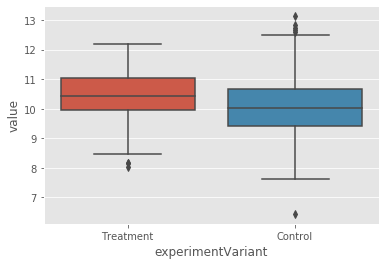

In [43]:
sns.boxplot(x="experimentVariant", y="value", data=data_ab)

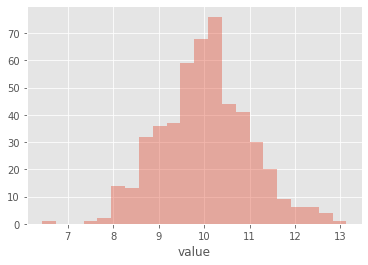

In [44]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Control'].value, kde=False)

In [45]:
sns.distplot(data_ab[data_ab.experimentVariant == 'Treatment'].value, kde=False)

In [47]:
mannwhitneyu(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=9508.0, pvalue=0.0026182097937983984)

In [48]:
ttest_ind(data_ab[data_ab.experimentVariant == 'Treatment'].value, 
             data_ab[data_ab.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.3318589655730135, pvalue=0.02006953912735476)

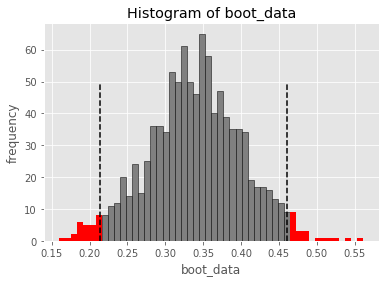

{'boot_data': [0.311642866467441,
  0.2803790000218313,
  0.4005482734655974,
  0.32241699979780175,
  0.2872937630089229,
  0.27287961160100044,
  0.40711603499799787,
  0.3690936793626043,
  0.31442313100356584,
  0.3264405369339072,
  0.3141494746140392,
  0.36217639930657425,
  0.3600679322461544,
  0.3822409502690522,
  0.25767715645642564,
  0.3502257291122056,
  0.45017909322063904,
  0.39331529641959173,
  0.37641133994118037,
  0.2733730365452141,
  0.35874696231011843,
  0.3192273055136867,
  0.27675144419167325,
  0.42658622136769625,
  0.2647589780577754,
  0.2503992450883882,
  0.5224798432298668,
  0.37170040799527326,
  0.4330724098946566,
  0.4275465872773983,
  0.3981626593726647,
  0.3063614609822789,
  0.33386657174716333,
  0.37546809912233653,
  0.44147520831410964,
  0.333238778578982,
  0.3241781100960534,
  0.3508647134722135,
  0.30965032230267353,
  0.39212007837745533,
  0.15967894149777367,
  0.3736640471691849,
  0.39730586129572465,
  0.561716758809035,
  

In [60]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [61]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

{'boot_data': [0.5147433326155504,
  0.3502958468606998,
  0.3481041014293007,
  0.3938835954395996,
  0.31773526043784983,
  0.5510466434841392,
  0.44702506285133037,
  0.4796694812157405,
  0.41662928095617957,
  0.5562520566066045,
  0.4563931507420982,
  0.2635290065303,
  0.45096901539327483,
  0.4403784659959049,
  0.47267379251589414,
  0.42715267588654005,
  0.3793186110718141,
  0.31207618843579965,
  0.4440736362395006,
  0.4937397514668307,
  0.41295553453867395,
  0.43867787050992035,
  0.44932367058575373,
  0.4083480114588003,
  0.3157690004779097,
  0.4233115252529842,
  0.4017388586352748,
  0.48701679063444914,
  0.465807153615831,
  0.41082097797400063,
  0.4186276357181846,
  0.45668777431082486,
  0.4080086980835773,
  0.4856184631233651,
  0.4205411114210005,
  0.37640103545195025,
  0.2400597077817146,
  0.485746095525065,
  0.41757160170829977,
  0.3933017157943697,
  0.47187506813098956,
  0.2488346699776498,
  0.47414759794946626,
  0.520738238910825,
  0.4479

In [49]:
5.4687657931866705e-08 < 0.0000002

True

In [24]:
ads_data = pd.read_csv('ads_data.csv.zip')

In [34]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .reset_index()

event   ad_id  click    view
0           3    9.0   490.0
1        2132    1.0    95.0
2        2276    2.0  1454.0
3        2475    NaN   132.0
4        2643    3.0   286.0
..        ...    ...     ...
350    121941    1.0   640.0
351    121943   15.0  1722.0
352    122042    1.0   155.0
353    122063    1.0   260.0
354    122086   50.0  1999.0

[355 rows x 3 columns]